# Introduction

Of the many datasets available on the UCI Machine Learning repository, one of the most popular ones is the *Adult Dataset*. It's a data extract from the 1994 Census database, containing information about various adults surveyed and, in particular, whether their income is more or less than $50,000 per year. It's a popular choice for testing classification algorithms to see how well this label can be predicted.

In this notebook I present my own approach for modelling this problem. Specifically I cover the following topics:

1. Loading and cleaning the data
2. Exploratory data analysis
3. Feature engineering
4. Machine learning to model the income label using i) logistic regression and ii) random forests
5. Feature importance

Link to dataset: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score

# Load data

In [2]:
df = pd.read_csv('adult_data.csv', header=None, skipinitialspace=True)

In [3]:
# Add column names
df.columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]

# Data exploration, cleaning and engineering

First let's inspect our data from different angles to get a sense of it.

In [4]:
# Get a first look at the top of the dataset and determine its size
display(df.head())
print("Table dimensions: " + str(df.shape))

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Table dimensions: (32561, 15)


So our dataset has 32,561 rows and 15 columns. Many of these columns are self-explanatory (e.g. age, race, sex) but with a bit of research online we can find out what some of the less-obvious ones mean:

*`fnlwgt` = "final weight" - the number of people that this specific individual represents (the census dataset has been reduced to be a more manageable size, so this is effecively a weighting variable).

*`education_num` = a number representation of the highest education level attained by the individual.

*`capital_gain` = capital earned through investments.

*`capital_loss` = capital lost through investments



We can drop `fnlwgt` as this is not a feature per se: the weighting of each row does not have any impact on our `income` label - it's something that was added after the census was completed to aid analysis of the data, i.e. it is a kind of meta-feature.

We can also drop `education_num` and `relationship` as these features will be highly correlated with `education` and `marital_status` respectively, which is something we want to avoid in machine learning models.

In [5]:
df = df.drop(['fnlwgt', 'education_num', 'relationship'], axis=1)

### Numeric variables

In [6]:
# Summary stats for numeric variables
df.describe()

,age,capital_gain,capital_loss,hours_per_week
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1077.648844,87.303830,40.437456
std,13.640433,7385.292085,402.960219,12.347429
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,48.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


The `capital_gain` and `capital_loss` distributions look quite skewed. We can use histograms to investigate this.

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/anaconda/envs/azureml_py3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f913ecd8860>,
      dtype=object)

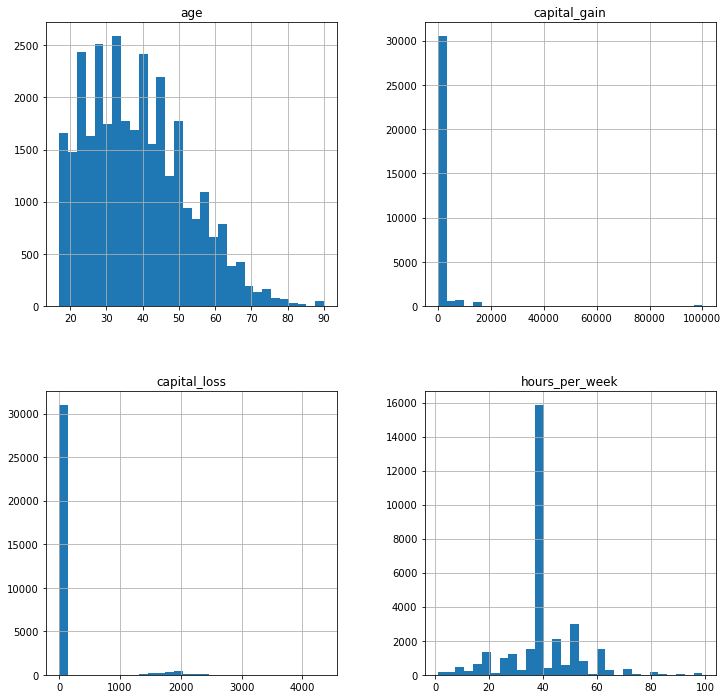

In [7]:
# Univariate distributions
df.hist(bins = 30, figsize=(12,12))

Indeed, the `capital_gain` and `capital_loss` variables are very right-skewed with the vast majority of values at zero. 

Let's take a closer look at the `capital_gain` variable with a boxplot.

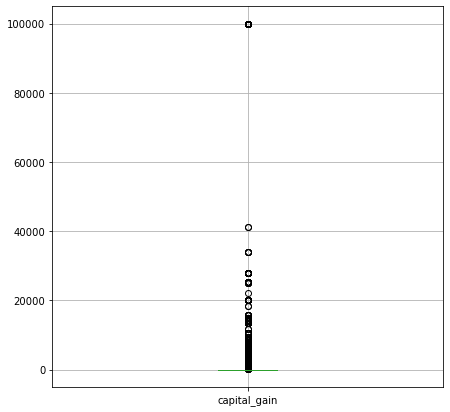

In [8]:
df[['capital_gain']].boxplot(figsize=(7,7))

Further investigation reveals that we have 159 values of 99999, which is more than double the next highest value of 41310. These outliers are most likely to be missing or unkown values, and the best course of action is to remove them from the data so as not to distort our models later on.

In [9]:
# Convert values of 99999 to NaN, which we will drop later
df[df['capital_gain']==99999] = np.nan

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f913c9ecb38>,
      dtype=object)

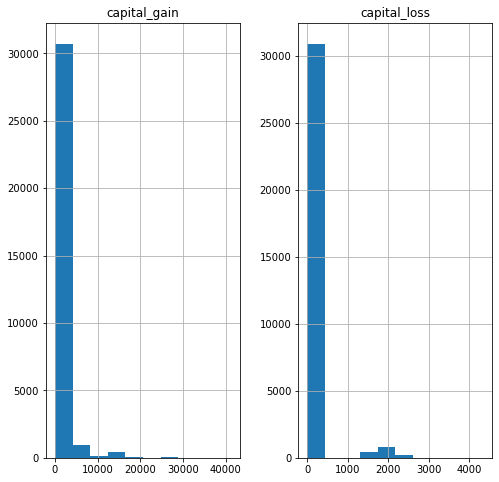

In [10]:
capital_cols = df[['capital_gain', 'capital_loss']].columns

subset = df[capital_cols]
subset.hist(figsize=(8,8))


To reduce the right-skew in the data let's apply a log transformation to both features.

In [11]:
df['log_cap_gain'] = np.log(df['capital_gain']+1)
df['log_cap_loss'] = np.log(df['capital_loss']+1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f913c82c630>,
      dtype=object)

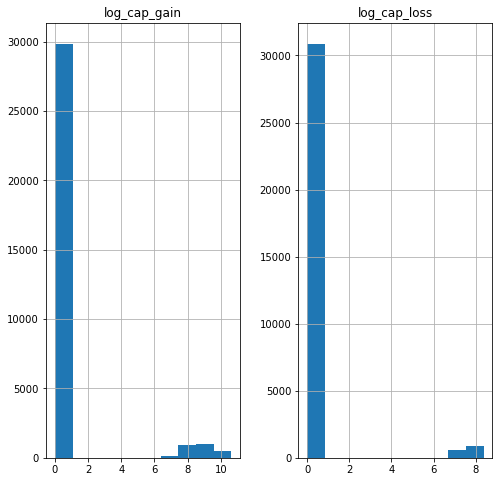

In [12]:
log_capital_cols = df[['log_cap_gain', 'log_cap_loss']].columns

subset = df[log_capital_cols]
subset.hist(figsize=(8,8))

These still don't look like normal distributions, so these features aren't ideal for a linear model. But it's better than what we had before.

Finally let's drop our old `capital_gain` and `capital_loss` variables.

In [13]:
df = df.drop(['capital_gain', 'capital_loss'], axis=1)

### Categorical variables

Let's now explore our categorical variables.

In [14]:
# Summary stats for categorical variables
df.describe(include="object")

,workclass,education,marital_status,occupation,race,sex,native_country,income
count,32402,32402,32402,32402,32402,32402,32402,32402
unique,9,16,7,15,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,White,Male,United-States,<=50K
freq,22614,10478,14844,4091,27676,21653,29028,24720


In [15]:
# Top 10 value counts for each category
for col in df.select_dtypes(include=['object']):
    print('-' * 40 + col + '-' * 40 , end=' - ')
    print('\t')
    print(df[col].value_counts().head(5))

----------------------------------------workclass---------------------------------------- - 	
Private             22614
Self-emp-not-inc     2512
Local-gov            2087
?                    1832
State-gov            1297
Name: workclass, dtype: int64
----------------------------------------education---------------------------------------- - 	
HS-grad         10478
Some-college     7277
Bachelors        5314
Masters          1705
Assoc-voc        1381
Name: education, dtype: int64
----------------------------------------marital_status---------------------------------------- - 	
Married-civ-spouse    14844
Never-married         10671
Divorced               4432
Separated              1023
Widowed                 992
Name: marital_status, dtype: int64
----------------------------------------occupation---------------------------------------- - 	
Craft-repair       4091
Prof-specialty     4073
Exec-managerial    4024
Adm-clerical       3764
Sales              3625
Name: occupation, dtype

Three issues jump out here:

1. The `native_country` variable has 42 possible values. This could cause dimensionality problems later on when we do one-hot encoding later. One option would be to group these countries (for example into continents), but in this case to save time I will simply delete the column (in fact 90% of the data is from the USA so there isn't a great deal of variance here anyway).  


2. For some of the categories one of the top values is a '?' symbol. This is clearly a missing value so we will recode it as such, and while we're at it drop all rows with missing data from the dataframe (there aren't many).  


3. Our label `income` needs to be recoded to being 0s and 1s rather than '<=50K' and '>50K', which is best practice in ML modelling.

In [16]:
# 1: dropping native_country column
df = df.drop(['native_country'], axis=1)

In [17]:
# 2. recoding ? as NaN and drop all missing values
df = df.replace(to_replace = '?', value = np.nan)
df = df.dropna()

In [18]:
# 3. Recoding label
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df['income'] = labelencoder.fit_transform(df['income'])

Regarding our labels, let's see what our distribution of each is.

In [19]:
df.income.value_counts(normalize=True)

0    0.754769
1    0.245231
Name: income, dtype: float64

So approximately 25% of the adults have an income of over $50k. This is an example of an imbalanced classification problem, which means that accuracy isn't a good metric for evaluating our models later on. Instead we will use area under the curve (AUC) of the ROC curve, which is better suited for these kind of tasks.

## Splitting the data

So we now have a dataset that has been cleaned, and we've done a bit of feature engineering to improve our more skewed numeric variables. At this point we need to split our dataset in order to properly evaluate our models later on without "cheating" by using information from our test set to inform our decision-making. This is called data leakage.

We will create a training set, a validation set and a test set which we will use at the end for testing our final model.

In [20]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=42)

y_train = df_train.income.values
y_val = df_val.income.values

del df_train['income']
del df_val['income']

Let's quickly check that our labels are distributed correctly in our splits.

In [21]:
pd.Series(y_train).value_counts(normalize=True)

0    0.754899
1    0.245101
dtype: float64

In [22]:
pd.Series(y_val).value_counts(normalize=True)

0    0.753253
1    0.246747
dtype: float64

Looks good, we can proceed.

# Exploratory data analysis

## Relationships between categorical features and label

Firstly we can investigate each category to see which subcategories within each one show above-average rates of high earners. We know that 24.5% of our overall census population are high-earners, so first we define this as a variable `global_mean`.

In [23]:
global_mean = df_train_full.income.mean()
global_mean

0.2456441717791411

Next we loop through all categorical variables to see how each subcategory compares to this global mean.

In [24]:
categorical = df_train_full.select_dtypes(include=['object']).columns.tolist()

In [25]:
for col in categorical:
    df_group = df_train_full.groupby(by=col).income.agg(['mean']).round(2)
    df_group['diff vs global'] = (df_group['mean'] - global_mean).round(2)
    df_group['ratio vs global'] = (df_group['mean'] / global_mean).round(2)
    display(df_group.sort_values('ratio vs global', ascending=False))

,mean,diff vs global,ratio vs global
workclass,,,
Self-emp-inc,0.55,0.30,2.24
Federal-gov,0.38,0.13,1.55
Local-gov,0.30,0.05,1.22
Self-emp-not-inc,0.28,0.03,1.14
State-gov,0.27,0.02,1.10
Private,0.22,-0.03,0.90
Without-pay,0.00,-0.25,0.00


,mean,diff vs global,ratio vs global
education,,,
Doctorate,0.77,0.52,3.13
Prof-school,0.70,0.45,2.85
Masters,0.55,0.30,2.24
Bachelors,0.42,0.17,1.71
Assoc-acdm,0.26,0.01,1.06
Assoc-voc,0.25,0.00,1.02
Some-college,0.20,-0.05,0.81
HS-grad,0.16,-0.09,0.65
12th,0.08,-0.17,0.33


,mean,diff vs global,ratio vs global
marital_status,,,
Married-AF-spouse,0.50,0.25,2.04
Married-civ-spouse,0.45,0.20,1.83
Divorced,0.11,-0.14,0.45
Widowed,0.10,-0.15,0.41
Married-spouse-absent,0.08,-0.17,0.33
Separated,0.07,-0.18,0.28
Never-married,0.05,-0.20,0.20


,mean,diff vs global,ratio vs global
occupation,,,
Exec-managerial,0.48,0.23,1.95
Prof-specialty,0.44,0.19,1.79
Protective-serv,0.32,0.07,1.30
Tech-support,0.30,0.05,1.22
Sales,0.27,0.02,1.10
Craft-repair,0.22,-0.03,0.90
Transport-moving,0.19,-0.06,0.77
Adm-clerical,0.14,-0.11,0.57
Farming-fishing,0.12,-0.13,0.49


,mean,diff vs global,ratio vs global
race,,,
Asian-Pac-Islander,0.28,0.03,1.14
White,0.26,0.01,1.06
Black,0.13,-0.12,0.53
Amer-Indian-Eskimo,0.12,-0.13,0.49
Other,0.08,-0.17,0.33


,mean,diff vs global,ratio vs global
sex,,,
Male,0.31,0.06,1.26
Female,0.11,-0.14,0.45


This tells us which groups of people have above-average rates of high earners within each category:

* **Workclass**: Self-employed adults and federal govt employees
* **Education**: People with doctorates, Masters and professional qualifications.
* **Marital status**: People with spouses.
* **Occupation**: Managerial executives and professional specialists.
* **Race**: Asian-Pac-Islanders and whites.
* **Sex**: Men.

These observations aren't particularly surprising compared to what we might have expected, which is a good sign.

### Categorial feature importance

The above is interesting but doesn't actually tell us which features are more important than others for our task. To do this, we can measure the degree of dependency between the label and each categorical feature using a metric called *mutual information*. 

In [26]:
from sklearn.metrics import mutual_info_score

In [27]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.income)

In [28]:
df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='Mutual information').round(3)
df_mi

,Mutual information
marital_status,0.107
education,0.063
occupation,0.062
sex,0.025
workclass,0.011
race,0.006


So `marital_status` is the most useful variable, followed by `education` and `occuption`. Interestingly the label doesn't show much dependence on `race` but we'll keep it in anyway for interest.

## Relationships between numeric variables and label

Let's compute the correlation between each numeric variable and the label to get an idea of what might be the most important ones for predicting `income`.

In [29]:
numerical = df_train_full.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [30]:
df_train_full[numerical].corrwith(df_train_full.income).sort_values(ascending=False)

income            1.000000
log_cap_gain      0.262929
age               0.236128
hours_per_week    0.223254
log_cap_loss      0.145079
dtype: float64

Unsurprisingly, being a higher earner shows some correlation with age, capital gains and hours worked per week. These correlation numbers aren't particularly high but also aren't tiny. It's worth keeping all of them in the data for modelling.


# One-hot encoding

Categorical variables are not suitable for machine learning models, which expect numbers in matrices as inputs. Therefore we need to convert our categorical data into matrix form. The most common way to do this is using one-hot encoding, in which we engineer new features for each subcategory and code their absence or presence in the data as a 0 or 1 respectively. Fortunatley Scikit-learn makes it easy for us do to this using the `DictVectorizer` class.

First we need to convert out training set to a dictionary object.

In [31]:
# Remove our label from the list of numeric variables
numerical.remove('income')

In [32]:
# Convert training set to a dictionary
train_dict = df_train[categorical + numerical].to_dict(orient='records')

Then we can use `DictVectorizer` to vectorise the dictionary. First we fit to the training set and then transform it to implement the one-hot encoding.

In [33]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
               sparse=False)

In [34]:
# Get our final set of features as a matrix
X_train = dv.transform(train_dict)

Let's see what our new set of features looks like now:

In [35]:
# dv.get_feature_names()
print(dv.get_feature_names())
print()
print("Number of features:" + str(len(dv.get_feature_names())))

['age', 'education=10th', 'education=11th', 'education=12th', 'education=1st-4th', 'education=5th-6th', 'education=7th-8th', 'education=9th', 'education=Assoc-acdm', 'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate', 'education=HS-grad', 'education=Masters', 'education=Preschool', 'education=Prof-school', 'education=Some-college', 'hours_per_week', 'log_cap_gain', 'log_cap_loss', 'marital_status=Divorced', 'marital_status=Married-AF-spouse', 'marital_status=Married-civ-spouse', 'marital_status=Married-spouse-absent', 'marital_status=Never-married', 'marital_status=Separated', 'marital_status=Widowed', 'occupation=Adm-clerical', 'occupation=Armed-Forces', 'occupation=Craft-repair', 'occupation=Exec-managerial', 'occupation=Farming-fishing', 'occupation=Handlers-cleaners', 'occupation=Machine-op-inspct', 'occupation=Other-service', 'occupation=Priv-house-serv', 'occupation=Prof-specialty', 'occupation=Protective-serv', 'occupation=Sales', 'occupation=Tech-support', 'occ

# Predictive Modelling

Our training data is all set. Now we can proceed to the machine learning itself.

We will compare the performance of two algorithms: logistic regression and random forest, which we all also tune. We will also discuss how we can get an idea of feature importance from each model.

## Logistic regression

We start with logistic regression. I will assume that the reader is familiar with this classification algorithm and will omit details of it here, aside from stating the formula here as a reminder:

$$
g(x_{i}) = sigmoid(w_{0} + x_{i}^{T}w)
$$

where $$ sigmoid(x) = \frac{1}{1+exp(-x)} $$

First we fit our model to the training data.

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Next we one-hot encode our validation set and use the model to make predictions on it.

In [38]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [39]:
y_pred_lr = model.predict_proba(X_val)[:, 1]

We can inspect our predictions array.

In [40]:
y_pred_lr

array([0.00763544, 0.01082819, 0.60447251, ..., 0.17725453, 0.2053483 ,
       0.73216426])

And finally get the AUC score.

In [41]:
roc_auc_score(y_val, y_pred_lr)

0.8832001740639723

Given that the perfect classifier would have an AUC of 1, a score of 0.88 is pretty good! Later on we will see how a random forest model compares, but firstly let's discuss feature importances.

## Feature importances

The magnitudes of the weights produced by the logistic regression can be interpreted as a crude estimate of feature importance: they allow us to see which features contribute most strongly to a positive prediction (>\\$50K) or a negative one (\\$50K). 

Note that to do this more thoroughly we should inspect the p-values produced by the model for each feature, but as a first pass this approach will do.

To see which feature is associated with each weight, we can use the `get_feature_names` method of the `DictVectorizer`, and zip the feature names together with the coefficients before looking at them.

In [42]:
d = dict(zip(dv.get_feature_names(), model.coef_[0].round(3)))

First let's see the features with the 10 largest weights:

Text(0.5, 1.0, '10 most positive feature weights for logistic regression model')

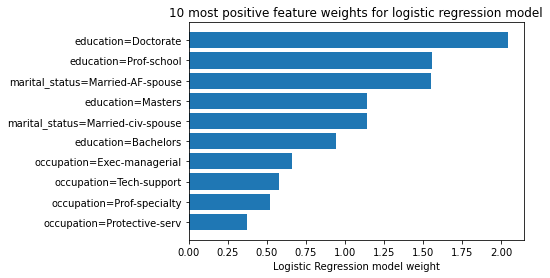

In [43]:
ft_imp = pd.DataFrame(d.items(), columns=['Feature', 'Coefficient'])
ft_imp_top_sorted = ft_imp.sort_values('Coefficient', ascending=False).head(10)
plt.barh(ft_imp_top_sorted.Feature, ft_imp_top_sorted.Coefficient)
plt.gca().invert_yaxis()
plt.xlabel('Logistic Regression model weight')
plt.title('10 most positive feature weights for logistic regression model')

Satisfyingly, this appears to corroborate our feature importance analysis from before modelling: higher education, professional/technical jobs and marriage are strong indicators of a higher salary.

Let's look at the features with the 10 most negative weights, which contribute most to a negative prediction (i.e. income <\\$50K)

Text(0.5, 1.0, '10 most negative feature weights for logistic regression model')

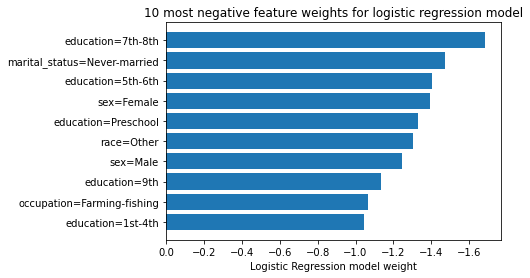

In [44]:
ft_imp = pd.DataFrame(d.items(), columns=['Feature', 'Coefficient'])
ft_imp_top_sorted = ft_imp.sort_values('Coefficient', ascending=False).tail(10)
plt.barh(ft_imp_top_sorted.Feature, ft_imp_top_sorted.Coefficient)
plt.gca().invert_xaxis()
plt.xlabel('Logistic Regression model weight')
plt.title('10 most negative feature weights for logistic regression model')

So as we might expect, having a lower education and being unmarried are strong indicators of a lower salary. Interestingly both `sex=Male` and `sex=Female` are also on this list - in a full project we would probably look to investigate this further using hypothesis testing.

## Random Forest

Next, let's investigate how a random forest performs for the same task. We will start off by using the default hyperparameter values to get a baseline model.

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
rf = RandomForestClassifier(random_state=3)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [47]:
y_pred_rf = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_rf)

0.8790362405751847

The AUC is actually slightly below that of the logistic regression model! Though the difference is minor - they both round to 0.88. 

## Tuning random forest model

Random forests have hyperparameters - parameters which, rather than being learnt by the model during training, need to be specified by the user before training. By finding more optimal values for these hyperparameters we can improve the performance of the model.

A popular way to determine these optimal values is randomized search, where values are selected randomly from a sensible range that we specify. Cross-validation is used so as to avoid using the validation set until the very end for comparison with the logistic regression model.

Key hyperparameters to tune for a random forest:

* `n_estimators`: number of trees in the forest
* `max_features`: number of features to consider when looking for the best split.
* `max_depth`: maximum depth of the tree
* `min_samples_split`: minmum number of samples required to split an internal node.
* `min_samples_leaf`: minimum number of samples required to be at a leaf node.

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3, 10]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
#                'bootstrap': bootstrap}
pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 3, 10],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}


In [49]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.5s
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

Let's see what the best hyperparameters selected were:

In [50]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 70}

In [51]:
# Inspect the best model
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Now we can run the tuned model on our validation set.

In [52]:
best_rf = rf_random.best_estimator_

y_pred_rf = best_rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_rf)

0.9047055117558463

The AUC is now 0.905 - higher than both the untuned random forest model and the logistic regression model!

Let's look at the ROC curve for a visualisation of the performance of both models:

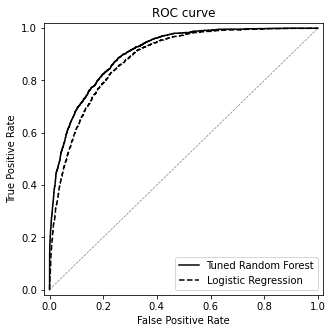

In [53]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred_rf)
plt.plot(fpr, tpr, color='black', label='Tuned Random Forest')

fpr, tpr, _ = roc_curve(y_val, y_pred_lr)
plt.plot(fpr, tpr, color='black', linestyle='dashed', label='Logistic Regression')

plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend()

plt.show()

Now we know that the tuned random forest gives the best results, we need to determine what the optimum threshold is for making predictions. For a balanced class problem we would usually use 0.5 (i.e. prediction probabilities greater than 0.5 mean a predicted class of 1) but this is an imbalanced class problem so we need to balance sensitivity and specificity. 

To determine the optimal threshold we can use the concept of the geometric mean, or G-mean. This allows us to find the optimum balance between sensitivity and specificity, i.e. a high true positive rate while keeping the false positive rate as low as possible.

In [54]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_rf)

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [55]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.270583, G-Mean=0.813


So the threshold is 0.26. We can visualise this on the ROC curve as follows.

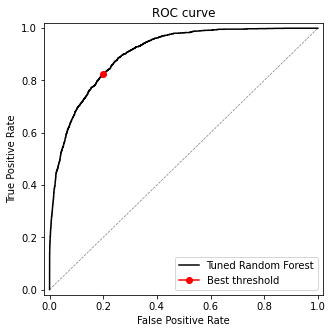

In [56]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred_rf)
plt.plot(fpr, tpr, color='black', label='Tuned Random Forest')

plt.plot(fpr[ix], tpr[ix], marker='o', color='red', label='Best threshold')

plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend()

plt.show()

## Evaluation of final model on test set

So we know that the tuned random forest gives better performance on the validation set than the logistic regression model. Let's see how it performs on the test set - we would expect it to give similar results to the validation set.

In [57]:
train_dict = df_train_full[categorical + numerical].to_dict(orient='records')
test_dict = df_test[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_test = dv.transform(test_dict)

y_test = df_test.income.values


In [58]:
final_y_pred_rf = best_rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, final_y_pred_rf)

0.9184586186823324

Our test set AUC score is actually a bit better than for the validation set! This is probably down to the fact that we were able to train our tuned random forest model on more data.

## Feature importances

One advantage of using random forest models is that it's easy for us to extract feature importances, which are built-in to the algorithm. 

Let's take a look at the top 10 most important ones.

In [59]:
feature_names = dv.get_feature_names()
np_feature_names = np.array(feature_names)

Text(0.5, 1.0, 'Top 10 most important features in random forest model')

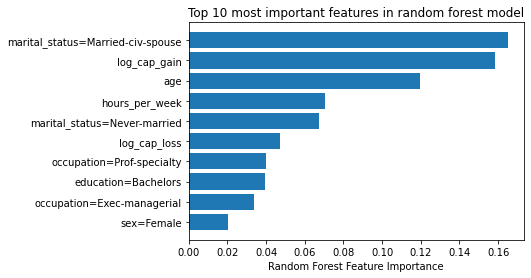

In [60]:
sorted_idx = best_rf.feature_importances_.argsort()
subset_sorted_idx = sorted_idx[-10:] # Get top 10
plt.barh(np_feature_names[subset_sorted_idx], best_rf.feature_importances_[subset_sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title('Top 10 most important features in random forest model')

So the most important features relate to whether the person is married or not, their capital gains, their age and hours worked per week. This confirms our findings from the exploratory data analysis stage, which is pleasing to see.

Note however that this doesn't give us an idea of whether these features influence more in a positive or negative direction, unlike with the logistic regression model. A better predictive model doesn't necessarily give more interpretable results - in fact often the opposite is true!

# References

Some resources I used to help me with this analysis:

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74  
https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/chapter-03-churn-prediction/03-churn.ipynb  
https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  